## Library and data import

In [7]:
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import evaluate
import torch
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

random.seed(12345)
color = "#4B1D91CC"

C:\Users\rami0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# check for GPU or MPS and set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
elif torch.backend.mps.is_available():
    device = torch.device("mps")
    print(f'There are {torch.mps.device_count()} MPS(s) available.')
    print('Device name:', torch.mps.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU or MPS available, using the CPU instead.')

There are 1 GPU(s) available.
Device name: NVIDIA GeForce RTX 2080 Ti


In [9]:
dataset = load_dataset("PolyAI/banking77")

# set the fortmat of the dataset to match torch
dataset.set_format(type="torch")

## Text exploration and preprocessing

In [10]:
# extracting the test and train splits
data_train = dataset["train"]
data_test = dataset["test"]

# extracting the labels
labels = data_train.features["label"].names

labels_df = pd.DataFrame(data_train["label"], columns=["label"])
test_labels_df = pd.DataFrame(data_test["label"], columns=["label"])

label2idx = {label: i for i, label in enumerate(labels)}
idx2label = {i: label for i, label in enumerate(labels)}

In [6]:
# sorting the labels by their frequency for a nicer plot
sorted_labels = labels_df["label"].value_counts().index

sorted_label_names = [labels[i] for i in sorted_labels]

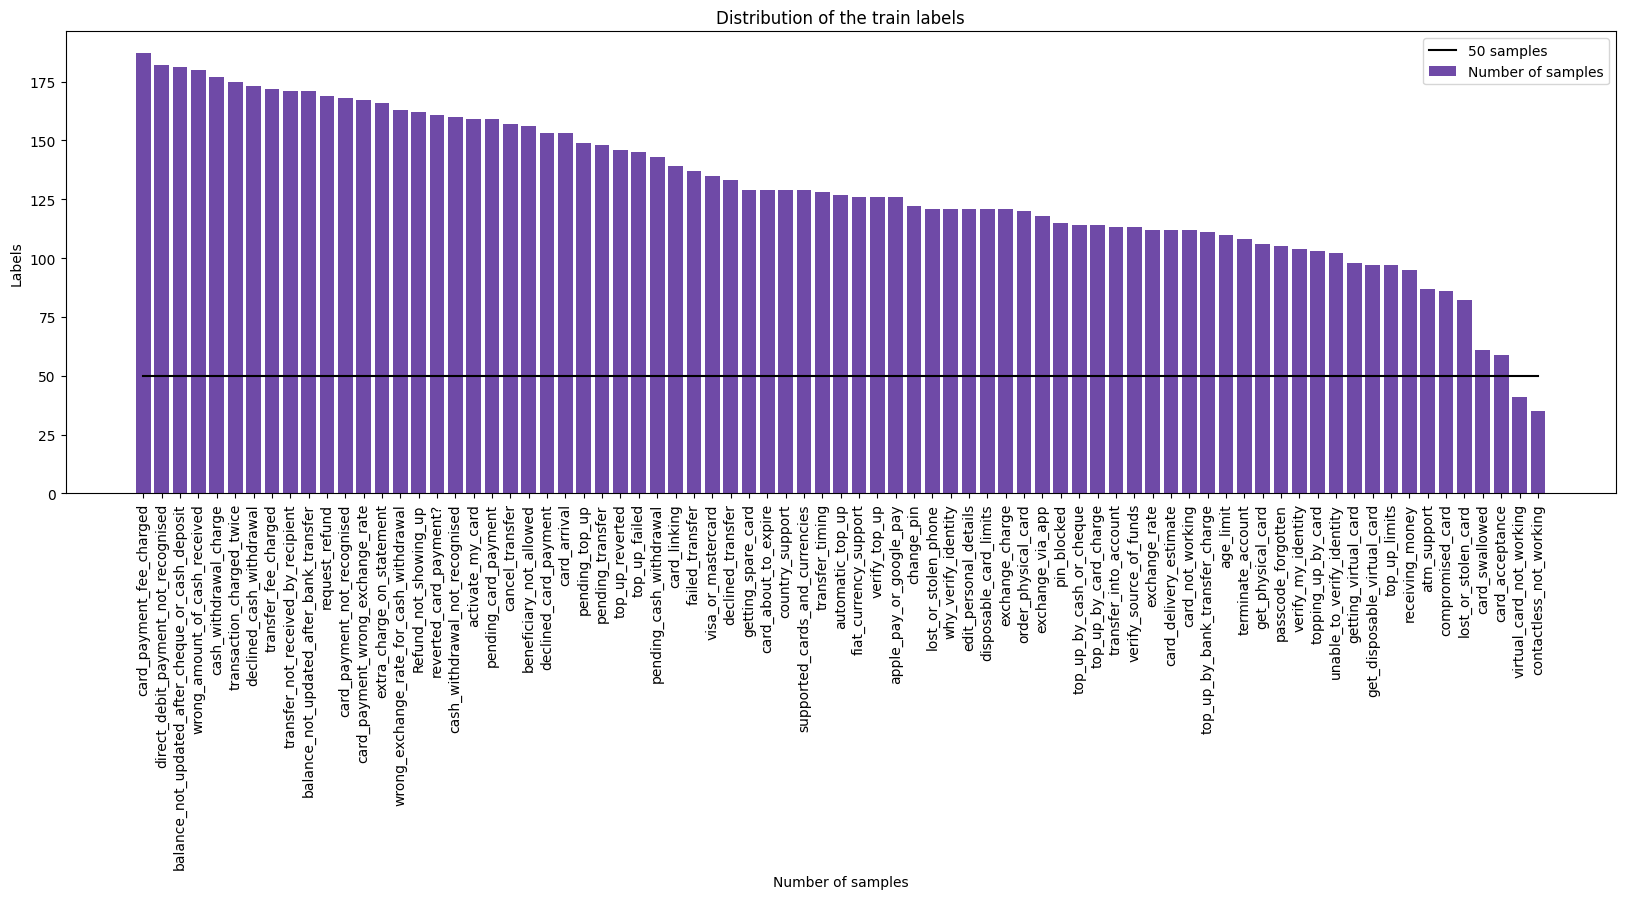

In [7]:
# plotting the distribution of the labels
plt.figure(figsize=(20, 6))
plt.bar(sorted_label_names, labels_df.value_counts(), color=color)
plt.plot(sorted_label_names, [50]*len(sorted_label_names), color="black")
plt.xticks(rotation=90)
plt.legend(["50 samples", "Number of samples"])
plt.title("Distribution of the train labels")
plt.xlabel("Number of samples")
plt.ylabel("Labels")
plt.show()

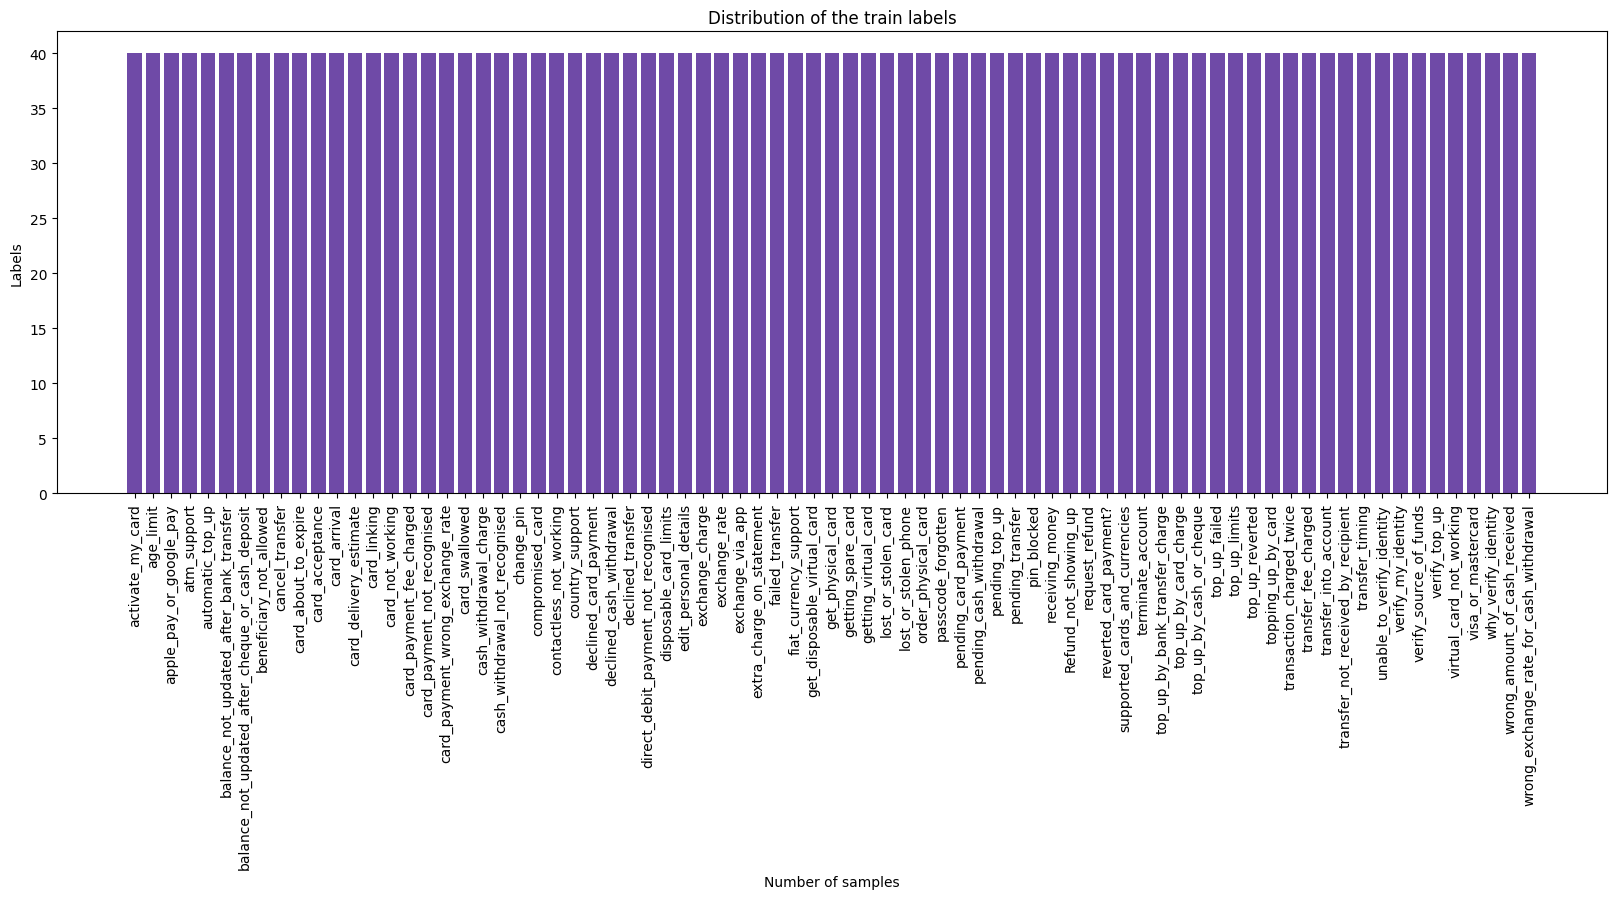

In [8]:
labels_count_test = pd.DataFrame(data_test["label"], columns=["label"])["label"].value_counts()

plt.figure(figsize=(20, 6))
plt.bar(labels, test_labels_df.value_counts(sort=False), color=color)
plt.xticks(rotation=90)
plt.title("Distribution of the train labels")
plt.xlabel("Number of samples")
plt.ylabel("Labels")
plt.show()

In [9]:
# display some random samples from the dataset
data_train.shuffle().select(range(10))["text"]

['Is there a fee for topping up a card?',
 'How many disposable cards per person?',
 'Does this app have the same exchange rate as third parties?',
 'I am traveling, what can I do to set up auto top-up?',
 'Can I get a physical card',
 'I have transfered to my account before but it is being declined now?',
 "It's been a week since you issued me a card and I still didn't get it. Should I keep waiting?",
 'How long does it take to make an urgent transfer from China?',
 'My billing address changed and I need to update my information.',
 'I made a mistake and performed a transaction on the wrong account!']

### Tokenization:
As I chose to use TF-IDF and DistilBERT, this section is to setup the vectorizer and tokenizer for both models.

In [136]:
tf_vectorizer = TfidfVectorizer(tokenizer=lambda text: text.split(), lowercase=True) # Not removing stop words increases the models performance

dbert_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_dbert(texts):
    '''
    Function to wrap the DistilBERT tokenizer and restrict the maximum length of the tokenized sequence to DistilBERT's maximum length.
    -----
    Use the Datasets .map() function to apply this function to the entire dataset (For the fastest results use batched=True).
    dataset_to_tokenize.map(preprocess_dbert, batched=True)

    Parameters
    ----------
    texts: str
        The text to be tokenized.

    Returns
    -------
    dict
        The tokenized text.
    '''
    return dbert_tokenizer(texts["text"], truncation=True)

In [137]:
# Vectorize the training data for TF-IDF
tf_train = tf_vectorizer.fit_transform(data_train["text"])
tf_test = tf_vectorizer.transform(data_test["text"])

C:\Users\rami0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [138]:
# Tokenize the dataset for DistilBERT
tokenized_data_dbert = dataset.map(preprocess_dbert, batched=True)

tokenized_data_dbert

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 3080
    })
})

In [139]:
# setup the data collator and evaluiation metrics
data_collator = DataCollatorWithPadding(tokenizer=dbert_tokenizer)

accuracy = evaluate.load("accuracy")
f1_score = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    acc = accuracy.compute(predictions=predictions, references=labels)
    f1 = f1_score.compute(predictions=predictions, references=labels, average="weighted")
    return {"accuracy": acc, "f1": f1}

## Training the models
### TF-IDF:
#### Initializing the model

In [140]:
# Initialize the SVM classifier
svm_clf_ovr = LinearSVC(max_iter=100000, dual=False, tol=1e-2)
svm_clf_crammer = LinearSVC(max_iter=100000, dual=False, tol=1e-5, multi_class="crammer_singer")

#### Fitting the model on the data

In [141]:
# Fit the SVM classifier on the vectorized training data
svm_clf_ovr.fit(tf_train, data_train["label"])
svm_clf_crammer.fit(tf_train, data_train["label"])

C:\Users\rami0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(dual=False, max_iter=100000, multi_class='crammer_singer', tol=1e-05)

In [142]:
# Calculate predicitons on the vectorized test data
y_pred_tf_ovr = svm_clf_ovr.predict(tf_test)
y_pred_tf_crammer = svm_clf_crammer.predict(tf_test)

accuracy_tf_ovr = accuracy.compute(predictions=y_pred_tf_ovr, references=data_test["label"])
f1_tf_ovr = f1_score.compute(predictions=y_pred_tf_ovr, references=data_test["label"], average="weighted")

accuracy_tf_crammer = accuracy.compute(predictions=y_pred_tf_crammer, references=data_test["label"])
f1_tf_crammer = f1_score.compute(predictions=y_pred_tf_crammer, references=data_test["label"], average="weighted")

print("TF-IDF Accuracy with OVR: ", accuracy_tf_ovr)
print("TF-IDF F1 Score with OVR: ", f1_tf_ovr)
print("TF-IDF Accuracy with Crammer: ", accuracy_tf_crammer)
print("TF-IDF F1 Score with Crammer: ", f1_tf_crammer)

TF-IDF Accuracy with OVR:  {'accuracy': 0.8821428571428571}
TF-IDF F1 Score with OVR:  {'f1': 0.8816450869137121}
TF-IDF Accuracy with Crammer:  {'accuracy': 0.8857142857142857}
TF-IDF F1 Score with Crammer:  {'f1': 0.8856343362093156}


Having tested multiple different hyperparameter setups (I didnt bother grid searching as there were so little hyperparameters to test anyway so I just used my intuition), I found that the only 2 hyperparameters that gave me truly better results were changing the multi-class strategy from "ovr" to "crammer_singer" and including stop-words in the vectorizer, most other hyperparameter changes just gave me marginally better or worse results in the 1/10th or less of a percent range.

### DistilBERT:

In [14]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, AutoConfig
from torchinfo import summary

# setup the config for the model
num_labels = dataset["train"].features["label"].num_classes

config = AutoConfig.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

In [15]:
# adjust the config to match number and name of labels in the dataset
config.id2label = idx2label.copy()
config.label2id = label2idx.copy()

config.id2label

{0: 'activate_my_card',
 1: 'age_limit',
 2: 'apple_pay_or_google_pay',
 3: 'atm_support',
 4: 'automatic_top_up',
 5: 'balance_not_updated_after_bank_transfer',
 6: 'balance_not_updated_after_cheque_or_cash_deposit',
 7: 'beneficiary_not_allowed',
 8: 'cancel_transfer',
 9: 'card_about_to_expire',
 10: 'card_acceptance',
 11: 'card_arrival',
 12: 'card_delivery_estimate',
 13: 'card_linking',
 14: 'card_not_working',
 15: 'card_payment_fee_charged',
 16: 'card_payment_not_recognised',
 17: 'card_payment_wrong_exchange_rate',
 18: 'card_swallowed',
 19: 'cash_withdrawal_charge',
 20: 'cash_withdrawal_not_recognised',
 21: 'change_pin',
 22: 'compromised_card',
 23: 'contactless_not_working',
 24: 'country_support',
 25: 'declined_card_payment',
 26: 'declined_cash_withdrawal',
 27: 'declined_transfer',
 28: 'direct_debit_payment_not_recognised',
 29: 'disposable_card_limits',
 30: 'edit_personal_details',
 31: 'exchange_charge',
 32: 'exchange_rate',
 33: 'exchange_via_app',
 34: 'extr

#### Setting up the model

In [150]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", config=config)

non_distil_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'classifier.

In [17]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              23,440,896
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           59,213
├─Dropout: 1-4                                          --
Total params: 67,012,685
Trainable params: 67,012,685
Non-trainable params: 0

#### Defining training arugments and trainer

In [151]:
# setting up the training arguments and trainer
output_dir = "./Models/distilbert_base_uncased"
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=1e-4,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data_dbert["train"],
    eval_dataset=tokenized_data_dbert["test"],
    data_collator=data_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

#### Non distiled BERT for curiosity:

In [152]:
output_dir = "./Models/bert_base_uncased"
training_args_bert = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,
    weight_decay=0.01,
    learning_rate=1e-4,
)

trainer_bert = Trainer(
    model=model,
    args=training_args_bert,
    train_dataset=tokenized_data_dbert["train"],
    eval_dataset=tokenized_data_dbert["test"],
    data_collator=data_collator,
    tokenizer=dbert_tokenizer,
    compute_metrics=compute_metrics
)

#### Training the model

In [155]:
trainer.train()

 20%|██        | 313/1565 [00:35<01:49, 11.48it/s]

{'eval_loss': 0.4136950969696045, 'eval_accuracy': {'accuracy': 0.9058441558441559}, 'eval_f1': {'f1': 0.9060107320727019}, 'eval_runtime': 2.4093, 'eval_samples_per_second': 1278.364, 'eval_steps_per_second': 20.338, 'epoch': 1.0}


 32%|███▏      | 502/1565 [00:55<01:42, 10.39it/s]

{'loss': 0.0974, 'learning_rate': 6.805111821086262e-05, 'epoch': 1.6}


 40%|████      | 626/1565 [01:12<01:22, 11.34it/s]

{'eval_loss': 0.3839930295944214, 'eval_accuracy': {'accuracy': 0.9207792207792208}, 'eval_f1': {'f1': 0.9209670309762171}, 'eval_runtime': 2.4113, 'eval_samples_per_second': 1277.312, 'eval_steps_per_second': 20.321, 'epoch': 2.0}


 60%|██████    | 939/1565 [01:48<00:58, 10.74it/s]

{'eval_loss': 0.3770512640476227, 'eval_accuracy': {'accuracy': 0.9282467532467532}, 'eval_f1': {'f1': 0.9282383702746585}, 'eval_runtime': 2.4868, 'eval_samples_per_second': 1238.515, 'eval_steps_per_second': 19.704, 'epoch': 3.0}


 64%|██████▍   | 1001/1565 [01:57<01:23,  6.73it/s]

{'loss': 0.0415, 'learning_rate': 3.610223642172524e-05, 'epoch': 3.19}


 80%|████████  | 1252/1565 [02:27<00:32,  9.62it/s]

{'eval_loss': 0.37440574169158936, 'eval_accuracy': {'accuracy': 0.9295454545454546}, 'eval_f1': {'f1': 0.9294711907234606}, 'eval_runtime': 2.6094, 'eval_samples_per_second': 1180.356, 'eval_steps_per_second': 18.778, 'epoch': 4.0}


 96%|█████████▌| 1500/1565 [02:55<00:05, 11.43it/s]

{'loss': 0.0079, 'learning_rate': 4.153354632587859e-06, 'epoch': 4.79}


100%|██████████| 1565/1565 [03:07<00:00,  6.44it/s]

{'eval_loss': 0.37336069345474243, 'eval_accuracy': {'accuracy': 0.9318181818181818}, 'eval_f1': {'f1': 0.931761811198371}, 'eval_runtime': 3.0289, 'eval_samples_per_second': 1016.867, 'eval_steps_per_second': 16.177, 'epoch': 5.0}


100%|██████████| 1565/1565 [03:07<00:00,  8.33it/s]

{'train_runtime': 187.939, 'train_samples_per_second': 266.124, 'train_steps_per_second': 8.327, 'train_loss': 0.047038128219854335, 'epoch': 5.0}


TrainOutput(global_step=1565, training_loss=0.047038128219854335, metrics={'train_runtime': 187.939, 'train_samples_per_second': 266.124, 'train_steps_per_second': 8.327, 'train_loss': 0.047038128219854335, 'epoch': 5.0})

In [153]:
trainer_bert.train()

  0%|          | 0/1565 [00:00<?, ?it/s]You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
                                                  
 20%|██        | 313/1565 [00:32<01:51, 11.25it/s]

{'eval_loss': 0.5605736374855042, 'eval_accuracy': {'accuracy': 0.8694805194805195}, 'eval_f1': {'f1': 0.8632383764972809}, 'eval_runtime': 2.3724, 'eval_samples_per_second': 1298.275, 'eval_steps_per_second': 20.654, 'epoch': 1.0}


 32%|███▏      | 502/1565 [00:53<01:35, 11.15it/s]

{'loss': 1.3465, 'learning_rate': 6.805111821086262e-05, 'epoch': 1.6}


                                                  
 40%|████      | 626/1565 [01:09<01:29, 10.46it/s]

{'eval_loss': 0.3440690338611603, 'eval_accuracy': {'accuracy': 0.9123376623376623}, 'eval_f1': {'f1': 0.9127017123917218}, 'eval_runtime': 2.4304, 'eval_samples_per_second': 1267.288, 'eval_steps_per_second': 20.161, 'epoch': 2.0}


                                                  
 60%|██████    | 939/1565 [01:45<00:57, 10.86it/s]

{'eval_loss': 0.28186461329460144, 'eval_accuracy': {'accuracy': 0.9262987012987013}, 'eval_f1': {'f1': 0.9263826267949322}, 'eval_runtime': 2.5584, 'eval_samples_per_second': 1203.898, 'eval_steps_per_second': 19.153, 'epoch': 3.0}


 64%|██████▍   | 1001/1565 [01:54<01:11,  7.87it/s]

{'loss': 0.1841, 'learning_rate': 3.610223642172524e-05, 'epoch': 3.19}


                                                   
 80%|████████  | 1252/1565 [02:24<00:30, 10.19it/s]

{'eval_loss': 0.2840113937854767, 'eval_accuracy': {'accuracy': 0.9275974025974026}, 'eval_f1': {'f1': 0.927696291077944}, 'eval_runtime': 2.5164, 'eval_samples_per_second': 1223.985, 'eval_steps_per_second': 19.472, 'epoch': 4.0}


 96%|█████████▌| 1501/1565 [02:52<00:05, 10.68it/s]

{'loss': 0.0515, 'learning_rate': 4.153354632587859e-06, 'epoch': 4.79}


                                                   
100%|██████████| 1565/1565 [03:04<00:00,  8.13it/s]

{'eval_loss': 0.27979621291160583, 'eval_accuracy': {'accuracy': 0.9327922077922078}, 'eval_f1': {'f1': 0.9328356856137137}, 'eval_runtime': 3.0519, 'eval_samples_per_second': 1009.202, 'eval_steps_per_second': 16.055, 'epoch': 5.0}


100%|██████████| 1565/1565 [03:04<00:00,  8.46it/s]

{'train_runtime': 184.9996, 'train_samples_per_second': 270.352, 'train_steps_per_second': 8.459, 'train_loss': 0.5065302624870032, 'epoch': 5.0}


TrainOutput(global_step=1565, training_loss=0.5065302624870032, metrics={'train_runtime': 184.9996, 'train_samples_per_second': 270.352, 'train_steps_per_second': 8.459, 'train_loss': 0.5065302624870032, 'epoch': 5.0})

In [156]:
trainer.create_model_card() # Creates a model card to quickly share the model's information

: 

In [ ]:
trainer_bert.create_model_card()

## Evaluating the models

In [25]:
from transformers import pipeline

In [115]:
# Get some random data from the dataset
random_eval_data = data_test.shuffle().select(range(100))
y_true = random_eval_data["label"]

In [106]:
for i in range(10):
    print(f"Question: {random_eval_data[i]['text']}")
    print(f"True label: {labels[random_eval_data[i]['label']]}")
    print("____________________________________________________")

Question: Why was a transaction on my card declined?
True label: declined_card_payment
____________________________________________________
Question: I want to choose a different PIN.
True label: change_pin
____________________________________________________
Question: I bought something and the money appeared back into my account? Why?
True label: reverted_card_payment?
____________________________________________________
Question: How old do my children need to be to open an account?
True label: age_limit
____________________________________________________
Question: How can i get multiple disposble cards.
True label: disposable_card_limits
____________________________________________________
Question: Why is my virtual card is being declined?
True label: virtual_card_not_working
____________________________________________________
Question: I cannot find my credit card.
True label: lost_or_stolen_card
____________________________________________________
Question: Can you tell me why

### TF-IDF:

In [146]:
random_eval_data_tf = tf_vectorizer.transform(random_eval_data["text"])

In [121]:
# Calculate predicitons on the randomly selected data
y_pred_tf_eval = svm_clf_crammer.predict(random_eval_data_tf)

print(y_pred_tf_eval[:10])
print(y_true[:10])

[25 21 53  1 39 40 62 61  6 42]
tensor([74, 43,  1, 16, 11, 41,  8, 18,  5, 57])


In [147]:
tf_idf_accuracy_eval = accuracy.compute(predictions=y_pred_tf_eval, references=y_true)
tf_idf_f1_eval = f1_score.compute(predictions=y_pred_tf_eval, references=y_true, average="weighted")

print("TF-IDF Accuracy: ", tf_idf_accuracy_eval)
print("TF-IDF F1 Score: ", tf_idf_f1_eval)

print("TF-IDF Accuracy of full test set: ", accuracy_tf_crammer)
print("TF-IDF F1 Score of full test set: ", f1_tf_crammer)

TF-IDF Accuracy:  {'accuracy': 0.04}
TF-IDF F1 Score:  {'f1': 0.047}
TF-IDF Accuracy of full test set:  {'accuracy': 0.8857142857142857}
TF-IDF F1 Score of full test set:  {'f1': 0.8856343362093156}


In [148]:
from joblib import dump, load

dump({
    'model': svm_clf_crammer,
    'vectorizer': tf_vectorizer,
}, './Models/TF_IDF_SVM/TF_IDF_SVM.model')

['./Models/TF_IDF_SVM/TF_IDF_SVM.model']

Clearly using a random subset of data to evaluate a TF-IDF model doesnt work too well, Im guessing this is because the sparse matrix created by the vectoriser doesnt contain all the classes/words that are in the test/train set therefore the vector space it creates is very different and cant be compared/used in the orgignal model. I would have to find the indecies of the randomlu selected text and then use those indecies to select the same indecies in the vector space created by the vectoriser to get a proper evaluation. But since I already performed a quick evaluation after training I feel thats a decent representation of the accuracy of the model.

### DistilBERT:

In [27]:
trained_model_dbert = AutoModelForSequenceClassification.from_pretrained(output_dir + '/checkpoint-1565', config=config)

dbert_pipe = pipeline("text-classification", model=trained_model_dbert, tokenizer=dbert_tokenizer, device=device)

In [29]:
trainer.model = trained_model_dbert

trainer.evaluate()

100%|██████████| 49/49 [00:02<00:00, 17.58it/s]


{'eval_loss': 0.2894761562347412,
 'eval_accuracy': {'accuracy': 0.9331168831168831},
 'eval_f1': {'f1': 0.9330621195005177},
 'eval_runtime': 3.15,
 'eval_samples_per_second': 977.782,
 'eval_steps_per_second': 15.556,
 'epoch': 5.0}

In [33]:
preds = dbert_pipe(random_eval_data["text"])
preds[:5]

[{'label': 'cash_withdrawal_not_recognised', 'score': 0.9318511486053467},
 {'label': 'top_up_by_cash_or_cheque', 'score': 0.9966187477111816},
 {'label': 'pending_transfer', 'score': 0.9948294758796692},
 {'label': 'order_physical_card', 'score': 0.9967513084411621},
 {'label': 'cash_withdrawal_charge', 'score': 0.9980379939079285}]

In [34]:
y_pred = [label2idx[pred["label"]] for pred in preds]
print(y_pred[:5])
print(y_true[:5])

[20, 58, 48, 43, 19]
tensor([20, 58, 48, 43, 19])


#### Calculate the metrics on the randomly selected eval data

In [35]:
print(f"Accuracy: {accuracy.compute(predictions=y_pred, references=y_true)}")
print(f"F1 score: {f1_score.compute(predictions=y_pred, references=y_true, average='weighted')}")

Accuracy: {'accuracy': 0.93}
F1 score: {'f1': 0.9326666666666666}
